In [ ]:
import torch

torch.cuda.is_available()

In [ ]:
import jax
import  flax.linen as nn

jax.devices()


In [ ]:
import flax.linen as nn
from jax import random
import jax.numpy as jnp

class Block(nn.Module):
  features: int


  @nn.compact
  def __call__(self, x, training: bool):
    x = nn.Dense(self.features)(x)
    x = nn.Dropout(0.5, deterministic=not training)(x)
    x = jax.nn.relu(x)
    return x

class Model(nn.Module):
  dmid: int
  dout: int


  @nn.compact
  def __call__(self, x, training: bool):
    x = Block(self.dmid)(x, training)
    x = nn.Dense(self.dout)(x)
    return x

model = Model(256, 10)
sample_x = jax.numpy.ones((1, 784))

# jax需要一个随机数种子来初始化参数，并且想要获取参数需要先输入一个伪输入变量
variables = model.init(
  random.key(0),
  sample_x, training=False # <== inputs
)
params = variables["params"]

params, type(params)

In [ ]:
import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.

tf.random.set_seed(0)  # Set the random seed for reproducibility.

train_steps = 1200
eval_every = 200
batch_size = 32

train_ds: tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize train set
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # Normalize the test set.

# Create a shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from.
train_ds = train_ds.repeat().shuffle(1024)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
from flax import nnx  # The Flax NNX API.
from functools import partial

class CNN(nnx.Module):
  """A simple CNN model."""

  def __init__(self, *, rngs: nnx.Rngs):
    conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), rngs=rngs)
    conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), rngs=rngs)
    avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
    linear1 = nnx.Linear(3136, 256, rngs=rngs)
    linear2 = nnx.Linear(256, 10, rngs=rngs)

  def __call__(self, x):
    x = avg_pool(nnx.relu(conv1(x)))
    x = avg_pool(nnx.relu(conv2(x)))
    x = x.reshape(x.shape[0], -1)  # flatten
    x = nnx.relu(self.linear1(x))
    x = self.linear2(x)
    return x

# Instantiate the model.
model = CNN(rngs=nnx.Rngs(0))
# Visualize it.
nnx.display(model)

In [ ]:
import jax.numpy as jnp  # JAX NumPy

y = model(jnp.ones((1, 28, 28, 1)))
nnx.display(y)

In [ ]:
import optax

learning_rate = 0.005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

In [ ]:
def loss_fn(model: CNN, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits

@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.

In [ ]:
metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

    print(
      f"[train] step: {step}, "
      f"loss: {metrics_history['train_loss'][-1]}, "
      f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
    )
    print(
      f"[test] step: {step}, "
      f"loss: {metrics_history['test_loss'][-1]}, "
      f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
    )

In [ ]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
import jax
import jax.numpy as jnp

# 啥意思？
# jax.vmap是jax的一个函数，用于向量化函数的输入和输出。
# in_axes参数指定输入的维度，out_axes参数指定输出的维度。
# 在这个例子中，in_axes=(0, 0)表示函数mul的两个输入x和y都是一维数组，out_axes=0表示函数mul的输出也是一维数组。
# @jax.vmap(in_axes=(0, 0), out_axes=0)
def mul(x, y):
    return x * y
x = jnp.arange(10000).reshape(50, 200)
y = jnp.arange(10000).reshape(50, 200)
vec_mul = jax.vmap(mul, in_axes=(1, 1), out_axes=1)
vec_result = vec_mul(x, y)
result = mul(x, y)
vec_result.shape # (200， 50)

In [ ]:
import numpy as np
import faiss

# 参数设置
D = 128    # 向量维度
N = 10000  # 数据库大小
M = 4      # 分块数
K = 256    # 每个子块的聚类数

# 生成随机数据
np.random.seed(42)
db_vectors = np.random.random((N, D)).astype('float32')
query_vectors = np.random.random((10, D)).astype('float32')

In [ ]:
import numpy as np
import faiss

# 参数设置
D = 4
M = 2
K = 2

# 生成模拟数据
np.random.seed(42)
db_vectors = np.array([[0.5, 0.6, 5.0, 5.1],
                       [1.0, 1.1, 4.5, 4.6]], dtype='float32')

# 训练PQ量化器
pq = faiss.ProductQuantizer(D, M, 1)
pq.train(db_vectors)

# 编码并重构
codes = pq.compute_codes(db_vectors)
reconstructed = pq.decode(codes)

print("码表:\n", codes)
print("原始向量:\n", db_vectors)
print("重构向量:\n", reconstructed)

In [ ]:
import numpy as np
import faiss

# 参数设置
D = 4
M = 2
K = 8

# 生成更多样化的模拟数据（1000个4维向量）
np.random.seed(42)
db_vectors = np.random.random((1000, D)).astype('float32') * 10  # 扩大数值范围

# 训练PQ量化器
pq = faiss.ProductQuantizer(D, M, K)
pq.train(db_vectors)  # 使用全部1000个向量进行训练

# 编码并重构测试向量
test_vectors = np.array([[0.5, 0.6, 5.0, 5.1],
                         [1.0, 1.1, 4.5, 4.6]], dtype='float32')
codes = pq.compute_codes(test_vectors)
reconstructed = pq.decode(codes)

print("码表:\n", codes)
print("原始测试向量:\n", test_vectors)
print("重构向量:\n", reconstructed)

In [ ]:
import numpy as np
import faiss

# 参数设置
D = 4
M = 2
N = 2  # 分块数
K = 2

# 生成模拟数据
np.random.seed(42)
db_vectors = np.array([[1, 2, 3, 4],
                       [5, 6, 7, 8]], dtype='float32')

# 训练PQ量化器
pq = faiss.ProductQuantizer(D, N, 1)
pq.train(db_vectors)

# 编码并重构
codes = pq.compute_codes(db_vectors)
reconstructed = pq.decode(codes)

print("码表:\n", codes)
print("原始向量:\n", db_vectors)
print("重构向量:\n", reconstructed)

In [ ]:
import torch

# 创建一个张量
tensor = torch.zeros(3, 3)
print("填充前：")
print(tensor)

# 使用 fill_ 填充
tensor.fill_(5)
print("填充后：")
print(tensor)

In [ ]:
import torch

class MyModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.param = torch.nn.Parameter(torch.rand(3, 4))
        self.linear = torch.nn.Linear(4, 5)

    def forward(self, x):
        return self.linear(x + self.param).clamp(min=0.0, max=1.0)
    


In [ ]:
module = MyModule()

from torch.fx import symbolic_trace
# Symbolic tracing frontend - captures the semantics of the module
symbolic_traced : torch.fx.GraphModule = symbolic_trace(module)

# High-level intermediate representation (IR) - Graph representation
# 打印查看FX的IR
print(symbolic_traced.graph)
"""
graph():
    %x : [#users=1] = placeholder[target=x]
    %param : [#users=1] = get_attr[target=param]
    %add : [#users=1] = call_function[target=operator.add](args = (%x, %param), kwargs = {})
    %linear : [#users=1] = call_module[target=linear](args = (%add,), kwargs = {})
    %clamp : [#users=1] = call_method[target=clamp](args = (%linear,), kwargs = {min: 0.0, max: 1.0})
    return clamp
"""

# Code generation - valid Python code
# 通过FX生成的代码，可以视为module中的forward代码
print(symbolic_traced.code)
"""
def forward(self, x):
    param = self.param
    add = x + param;  x = param = None
    linear = self.linear(add);  add = None
    clamp = linear.clamp(min = 0.0, max = 1.0);  linear = None
    return clamp
"""

In [ ]:
class LinearTempDecay:
    def __init__(self, t_max: int, rel_start_decay: float = 0.2, start_b: int = 10, end_b: int = 2):
        self.t_max = t_max
        self.start_decay = rel_start_decay * t_max
        self.start_b = start_b
        self.end_b = end_b

    def __call__(self, t):
        """
        Linear annealing scheduler for temperature b.
        :param t: the current time step
        :return: scheduled temperature
        """
        if t < self.start_decay:
            return self.start_b
        else:
            rel_t = (t - self.start_decay) / (self.t_max - self.start_decay)
            return self.end_b + (self.start_b - self.end_b) * max(0.0, (1 - rel_t))

scheduler = LinearTempDecay(t_max=100, rel_start_decay=0.2, start_b=10, end_b=2)

for t in range(101):
    current_temp = scheduler(t)
    print(f"Step {t}: Temperature = {current_temp:.2f}")

In [ ]:
from quanlib.adaround.QPlif import QPlif
import torch
neuron = QPlif(bit = 8, ptq = True).to('cuda')
ds = {'v_threshold': 0.5, 'v_reset': None, 'decay_input': False, 'init_tau':2.0, 'detach_reset': False}
for i in ds.keys():
  setattr(neuron, i, ds[i])
torch.random.manual_seed(0)
x = torch.rand(1, 8).to('cuda') * 2
print(x)
for key in ds:
  print(key, ': ', getattr(neuron, key))
neuron.origin = True
# origin
for i in range(3):
  y = neuron(x)
  print('self.v: ', neuron.v.data + y * 0.5)
  print(y.data)

print('=' * 20, 'quan', '=' * 20)
neuron.reset()
neuron.origin = False
# quan
# neuron.v_threshold = 0.5
for key in ds:
  print(key, ': ', getattr(neuron, key))
for i in range(3):
  y = neuron(x)
  print(y)
  

In [ ]:
from quanlib.adaround.QPlif import QPlif
import torch
neuron = QPlif(bit = 8, ptq = True).to('cuda')
for para in neuron.parameters():
    para.requires_grad = False
    print(para)

In [ ]:
import torch
linears = ['sigma_net.0', 'sigma_net.2', 'color_net.0', 'color_net.2', 'color_net.4']
model = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/checkpoints/quan.pth')
# for key in model['model'].keys():
    # if 'weight_quantizer.scale_exp' in key:
    #     scale_exp = torch.round(model['model'][key])
    #     # int_weight = torch.clamp(torch.round())
    # if 'alpha' in key:
    #     alpha = model['model'][key]
    #     print(f"{key}: {alpha.shape}, value: {alpha}")
    
#     for key in model['model'].keys():
#         if 'max_val' in key or 'min_val' in key:
#             if model['model'][key].shape == torch.Size([]):
#                 model['model'][key] = model['model'][key].unsqueeze(0)
#                 print(f'{key}: {model['model'][key].shape}')
# torch.save(model, '/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/checkpoints/quan.pth')
new_state = {}
for layer in linears:
    weight = model['model'][layer + '.weight']
    scale_exp = model['model'][layer + '.weight_quantizer.scale_exp']
    int_weight = torch.clamp(torch.round(weight /2 **  torch.round(scale_exp)), -128, 127) + (model['model'][layer + '.weight_quantizer.alpha'] > 0).float()
    int_weight = int_weight.to(torch.int8)
    print(f"{layer} int weight: {int_weight}")
    new_state[layer + '.weight'] = int_weight
    # new_state[layer + '.weight_quantizer.scale_exp'] = model['model'][layer + '.weight_quantizer.scale_exp']
for key in model['model'].keys():
    if 'scale_exp' in key or 'alpha' in key:
        print(f"{key}: {model['model'][key].shape}, value: {model['model'][key]}")
        new_state[key] = model['model'][key]
        
# torch.save(new_state, '/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/checkpoints/quan_hardware.pth')


In [ ]:
import torch
a = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/color_linear_0_t0.pt')
b = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/color_linear_0_t1.pt')

c = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/sigma_linear_0_t1.pt')
d = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/sigma_linear_0_t0.pt')

mem = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/sigma_Qplif_Mem_1_t0.pt')
out = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/sigma_linear_2_t0.pt')

model = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/checkpoints/quan.pth')
v_th = 0.5 * torch.sigmoid(model['model']['sigma_net.1.vth_alpha'])
spike = (mem > v_th).float()
torch.equal(spike, out)

In [ ]:
import torch

embeddings = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/checkpoints/quan.pth')['model']['encoder.embeddings']
offsets = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/checkpoints/quan.pth')['model']['encoder.offsets']
feature_grids = []

def quant_scale(x, bit):
    scale_list = []
    maxs, mins = x.max(), x.min()
    scale = min(torch.abs(maxs), torch.abs(mins)) * 2 / (2 ** bit - 1)
    return scale

def close_to_2(x, mode = 'round'):
    if mode == 'round':
        ids = torch.round(torch.log2(x))
    elif mode == 'floor':
        ids = torch.floor(torch.log2(x))
    elif mode == 'ceil':
        ids = torch.ceil(torch.log2(x))
    else:
        raise ValueError("mode should be 'round' or 'floor'")
    return torch.tensor(2 ** ids)

for i in range(1, offsets.shape[0]):
    grid = embeddings[offsets[i-1]:offsets[i]]
    print(f"Grid {i}: shape={grid.shape}, mean={grid.mean():.4f}, std={grid.std():.4f}, min={grid.min():.4f}, max={grid.max():.4f}")
    feature_grids.append(grid.flatten())

bit = 4
for i in range(len(feature_grids)):
    scale = quant_scale(feature_grids[i], bit)
    scale = close_to_2(scale, 'ceil')
    print(f"{i}-th level: Feature scale: {scale:.4f}")
    new = torch.clamp(torch.round(feature_grids[i] / scale), -2**(bit-1), 2**(bit-1)-1) * scale
    feature_grids[i] = new.cpu().numpy()
# torch.save(feature_grids, '/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/checkpoints/feature_grids_4bit.pt')
# type(feature_grids), type(feature_grids[0])

In [ ]:
import torch

feature_grids_list = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/checkpoints/feature_grids_4bit.pt')
for i in range(len(feature_grids)):
    print(feature_grids[i].mean(), feature_grids[i].std())

In [ ]:
a = [33.99, 26.70, 32.10, 36.99, 35.31, 30.80, 34.41, 28.90]
qa = [32.85, 26.01, 31.72, 35.60, 34.90, 30.48, 34.15, 28.62]
apsnr = 0
qpsnr = 0
for i in range(len(a)):
    apsnr += a[i]
    qpsnr += qa[i]
    print(a[i] - qa[i])
apsnr /= len(a)
qpsnr /= len(a)

apsnr, qpsnr

In [ ]:
import torch

data0 = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit7/0data.pt')
data1 = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit7/1data.pt')

data0['rays_o'].shape, data1['rays_o'].shape
data0['rays_o'][2, 2], data0['rays_o'][2000, 2], data0['rays_o'][4000, 2], data1['rays_o'][4200, 2], data1.keys()
data1['images'].shape, data0['images'].shape

In [ ]:
import torch

inputs = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/sigma_Qplif_input_1_t0.pt')
mem = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/sigma_Qplif_Mem_1_t0.pt')
mem2 = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/sigma_Qplif_Mem_1_t1.pt')
models = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/checkpoints/quan.pth')['model']
input_scale = 2**torch.round(models['sigma_net.1.input_quantizer.scale_exp'])
mem_scale = 2**torch.round(models['sigma_net.1.Mem_quantizer.scale_exp'] + 1)
print(models['sigma_net.1.input_quantizer.scale_exp'], models['sigma_net.1.Mem_quantizer.scale_exp'])

def quant(x, scale, bit = 8):
    return torch.clamp(torch.round(x / scale), -2 ** (bit - 1), 2 ** (bit - 1) - 1)

def dequant(x, s):
    return x * s

finput = dequant(quant(inputs, input_scale), input_scale)

fmem = dequant(quant(inputs, mem_scale), mem_scale)

# torch.equal(fmem ,mem)
fmem[1, :100] / mem_scale, mem[1, :100] / mem_scale, 
torch.max(torch.abs(fmem - mem) / mem_scale)

In [ ]:
hardware = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit/checkpoints/quan_hardware.pth')
hardware.keys()
hardware['sigma_net.1.input_quantizer.scale_exp'], hardware['sigma_net.1.Mem_quantizer.scale_exp']

In [ ]:
import torch
model = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_6_6bitV5/checkpoints/quan.pth')['model']

for key in model.keys():
    if 'vth' in key:
        print(key, torch.sigmoid(model[key]) * 0.5)
    elif 'mem_threshold' in key:
        print(key, torch.sigmoid(model[key]) * 4.0)

In [ ]:
import torch
new_state = {}
model = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit22/checkpoints/quan.pth')
for key in model['model'].keys():
    if 'max_val' in key or 'min_val' in key:
        if model['model'][key].shape == torch.Size([]):
            model['model'][key] = model['model'][key].unsqueeze(0)
            print(f'{key}: {model['model'][key].shape}')
        # print(f'{key}: {model[key].shape}')
    if 'scale_exp' in key:
        new_state[key] = torch.ceil(model['model'][key])
    elif 'vth' in key:
        new_state[key] = model['model'][key]
    
    if '.weight' in key and 'weight_quant' not in key and 'lora' not in key:
        layer = key.split('.')[0] + '.' + key.split('.')[1]
        weight = model['model'][key]
        print(weight.shape)
        weight = torch.clamp(torch.round(weight /  (2 ** torch.ceil(model['model'][layer + '.weight_quantizer.scale_exp']))), -128, 127) * 2 ** torch.ceil(model['model'][layer + '.weight_quantizer.scale_exp'])
        new_state[key] = weight
    
new_state.keys()
# torch.save(model, '/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit22/checkpoints/quan.pth')
torch.save(model, '/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_8_8bit22/checkpoints/quan_hardware.pth')


In [ ]:
import torch

model = torch.load('/home/liuwh/lrx/PATA_code/ngp_ep0300.pth')
for key in model['model'].keys():
    if '.w' in key and '.weight' not in key:
        print(key, 1 / torch.sigmoid(model['model'][key]))


In [ ]:
import torch

a = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_4_4bit6/checkpoints/quan.pth')['model']
b = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/chair_symmetric_4_4bit3/checkpoints/quan.pth')['model']

for key in a.keys():
    if 'scale_exp' in key:
        print(f'{key}: version 6: {torch.round(a[key])}, version 3: {torch.round(b[key])}')

In [ ]:
import torch
import os
c = [1, 2,  0, 8]
a = torch.tensor([1, 2,  0, 8])
b = a[torch.argmin(a)]
b, c[:-1]

f = ['a', 'b', 'c']
'.'.join(f)

In [ ]:
p = [21.900959,	27.303768,	24.907370,	22.577078,	25.547709,	28.811499,	18.307999]
s = [0.442258,	0.817291,	0.723945,	0.535923,	0.681843,	0.848530,	0.332506]
l = [0.584337,	0.329275,	0.403961,	0.450397,	0.370903,	0.331776,	0.653977]
def avg(p):
    ap = 0
    for i in p:
        ap += i
        
    ap /= len(p)
    return ap
avg(p), avg(s), avg(l)

In [ ]:
import torch

model = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/fix_time/G4W4A4/nerf_synthetic/mic/checkpoints/quan.pth')['model']
# for key in model.keys():
#     print(key)
i = 59
bitfield = model['density_bitfield']
grid = model['density_grid']
bitfield.shape[0] * 8, grid.shape, 128 ** 3
grid

In [ ]:
import torch

def close_to_2(x, mode = 'round'):
    if mode == 'round':
        ids = torch.round(torch.log2(x))
    elif mode == 'floor':
        ids = torch.floor(torch.log2(x))
    elif mode == 'ceil':
        ids = torch.ceil(torch.log2(x))
    else:
        raise ValueError("mode should be 'round' or 'floor'")
    return torch.tensor(2 ** ids), ids

def quan_embedding(bit, embeddings, offsets):
    bit = bit
    quant_embeddings = torch.zeros_like(embeddings)
    
    print(f'[INFO] Init Quant Embeddings')
    for i in range(1, offsets.shape[0]):
        tmp_embedding = embeddings[offsets[i-1] : offsets[i]]
        maxs = torch.max(tmp_embedding)
        mins = torch.min(tmp_embedding)
        scale = torch.min(torch.abs(maxs), torch.abs(mins)) / (2 ** bit - 1)
        pot_scale, _ = close_to_2(scale, 'round')
        quant_tmp = torch.clamp(torch.round(tmp_embedding / pot_scale), - 2 ** (bit - 1), 2 ** (bit - 1) -1)
        fake_tmp = quant_tmp * pot_scale
        quant_embeddings[offsets[i-1] : offsets[i]] = fake_tmp
    print(f'[INFO] Init Quant Embeddings over')
    return quant_embeddings
    
    
model = torch.load('/home/liuwh/lrx/PATA_code/workspace/quan/fix_time/G8W8A4/Ablation_no_clamp/materials/checkpoints/quan.pth')['model']
embeddings = model['encoder.embeddings']
offsets = model['encoder.offsets']

mlp_para = 16 * 64 + 64 * 64 + 64 * 16 + 64 * 31 + 64 * 3

# for key in model.keys():
#     print(key)
print(offsets.shape)
qe = quan_embedding(8, embeddings, offsets)
ids = torch.nonzero(qe)
tn = embeddings.shape[0] * embeddings.shape[1]
nzn = ids.shape[0]
f'{nzn / tn * 100 : .2f}%, {embeddings.shape}, {qe.shape}'

(6098120 * 2 * 1 * 0.9585 + mlp_para * 1 ) / ((6098120 * 2 + mlp_para) * 4), 1- 0.2396

In [ ]:
import torch

a = torch.tensor(0.8568035364151001)
a.sigmoid(), 31.78 - 28.82, 2.96 / 31.78, (31.78 - 24.75) / 31.78

/tmp/ipykernel_889900/32215203.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_data = torch.load('/home/liuwh/lrx/PATA_code/workspace/intermediate_data/W4U4_wi

torch.Size([267876, 64]) torch.Size([267876, 64]) torch.Size([267876, 64])
vth: clamp 0.478860467672348, no clamp 0.48605671525001526


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

(32,) (32,) (32,)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

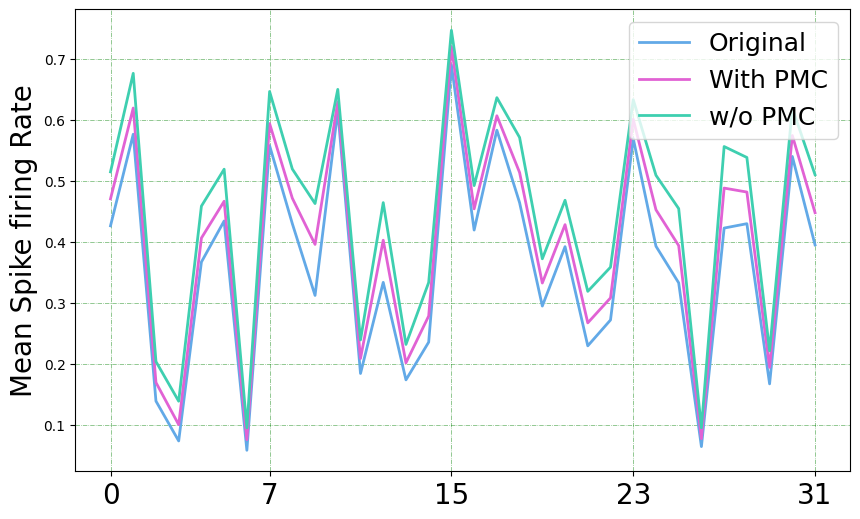

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
# 模拟三组数据，维度为 [N, 64]，这里用随机数据代替，你需要替换为真实数据
# 假设N为100，仅作示例

def spike(x, vth):
    out = (x >= vth).float()
    return out

N = 100
original_data = torch.load('/home/liuwh/lrx/PATA_code/workspace/intermediate_data/W4U4_with_Clamp/LIF/sigma_net_0_original_Mem.pt')
quantization_scheme1_data = torch.load('/home/liuwh/lrx/PATA_code/workspace/intermediate_data/W4U4_with_Clamp/QLIF/sigma_net_0_quant_Mem.pt')   # clamp
quantization_scheme2_data = torch.load('/home/liuwh/lrx/PATA_code/workspace/intermediate_data/W4U4_without_Clamp/QLIF/sigma_net_0_quant_Mem.pt')  # no clamp
print(original_data[0].shape, quantization_scheme1_data[0].shape, quantization_scheme2_data[0].shape)
# 计算每组数据在维度上的均值，作为纵轴的值

def plots(original_mean, quantization_scheme1_mean, quantization_scheme2_mean):
    
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rc("legend", fontsize=18)
    # 横轴坐标
    x_axis = np.arange(original_mean.shape[0])
    
    # 创建画布和子图
    fig, ax = plt.subplots(figsize=(10, 6))

    # 绘制原始模型膜电位的折线
    ax.plot(x_axis, original_mean, label='Original', linewidth=2.0,color =  "#62A9E7")# , marker='o' 加粗

    # 绘制量化方案1膜电位的折线
    ax.plot(x_axis, quantization_scheme1_mean, label='With PMC', linewidth=2.0,color =  "#E162D4")# , marker='s'

    # 绘制量化方案2膜电位的折线
    ax.plot(x_axis, quantization_scheme2_mean, label='w/o PMC', linewidth=2.0,color =  "#3ECFB0")# , marker='^'

    # 设置坐标轴标签
    # ax.set_xlabel('Index (0-63)')
    ax.set_ylabel('Mean Spike firing Rate', fontsize=20)
    plt.xticks([0, 7, 15, 23, 31], fontsize=20)
    # 设置标题
    # ax.set_title('Comparison of Membrane Potentials among Different Schemes')

    # 添加图例
    ax.legend()

    # 显示网格线，方便查看数值
    ax.grid(True, c='g',linestyle='-.', linewidth=0.5, alpha=0.6)

    # 显示图形
    plt.show()

clamp_vscale = torch.load('/home/liuwh/lrx/PATA_code/workspace/intermediate_data/W4U4_with_Clamp/QLIF/sigma_net_0_Mem_scale_vth.pt')
vthq = 0.5 * torch.sigmoid(clamp_vscale[1])

woclamp_vscale = torch.load('/home/liuwh/lrx/PATA_code/workspace/intermediate_data/W4U4_without_Clamp/QLIF/sigma_net_0_Mem_scale_vth.pt')
vthwq = 0.5 * torch.sigmoid(woclamp_vscale[1])  

print(f'vth: clamp {vthq}, no clamp {vthwq}')


i = 1
ids = 32
ori = np.mean(original_data[i].cpu().numpy(), axis=0)
clamp = np.mean(quantization_scheme1_data[i].detach().cpu().numpy(), axis=0)
woclamp = np.mean(quantization_scheme2_data[i].detach().cpu().numpy(), axis=0)

ori_spike = np.mean(spike(original_data[i], 0.5).cpu().numpy(), axis=0)
clamp_spike = np.mean(spike(quantization_scheme1_data[i], vthq).detach().cpu().numpy(), axis=0)
woclamp_spike = np.mean(spike(quantization_scheme2_data[i], vthwq).detach().cpu().numpy(), axis=0)
print(ori_spike[:32].shape, clamp_spike[:32].shape, woclamp_spike[:32].shape)
plots(ori_spike[:32], clamp_spike[:32], woclamp_spike[:32])

In [19]:
import torch

net = torch.load('/home/linrx/Code/PATA_Quan/workspace/synthetic_nerf/ann/lego/checkpoints/ngp_ep0600.pth')

net['ema'].keys()

# offsets = net['model']['encoder.offsets']
# embeddings = net['model']['encoder.embeddings']
# def export_embeddings(offsets, embeddings):
#     offsets = torch.tensor(offsets)
#     shifts = offsets[1:] - offsets[:-1]
#     print(shifts)
# z = embeddings[offsets[0]:offsets[1], :].zero_()
# embeddings.numel(), torch.sum(torch.abs(embeddings) > 1e-6).item()
for i in net['ema']['shadow_params']:
    print(i.shape)

torch.Size([6098120, 2])
torch.Size([64, 32])
torch.Size([16, 64])
torch.Size([64, 31])
torch.Size([64, 64])
torch.Size([3, 64])


/tmp/ipykernel_117926/3242766211.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load('/home/linrx/Code/PATA_Quan/workspace/synthetic_nerf/ann/lego/checkpoin

In [50]:
import torch
torch.random.manual_seed(0)
a = torch.rand(4, 4)
b = torch.rand(4, 4)

def quant(x, bit = 8):
    scale = torch.max(torch.abs(torch.max(x)), torch.abs(torch.min(x))) * 2 / (2 ** bit - 1)
    return torch.clamp(torch.round(x / scale), -2 ** (bit - 1), 2 ** (bit - 1) - 1), scale
qa, sa = quant(a, 8)
qb, sb = quant(b, 8)

c = a @ b.t()
qc = qa @ qb.t()
sc = sa * sb
quant_c, q_sc = quant(c, 8)
abc_qc, abc_qsc = quant(qc * sc, 8)

abc_qc, c / abc_qsc, (qc * (sc / abc_qsc)).round()

(tensor([[ 73.,  86.,  52.,  39.],
         [ 76., 127.,  71.,  93.],
         [ 72., 100.,  64.,  58.],
         [ 25.,  54.,  29.,  47.]]),
 tensor([[ 73.2186,  86.2050,  52.2174,  38.2493],
         [ 76.2117, 127.8815,  70.7992,  92.4874],
         [ 71.8429,  99.7358,  64.2001,  57.9601],
         [ 24.9061,  53.5025,  29.0378,  46.2980]]),
 tensor([[ 73.,  86.,  52.,  39.],
         [ 76., 127.,  71.,  93.],
         [ 72., 100.,  64.,  58.],
         [ 25.,  54.,  29.,  47.]]))

In [9]:
import torch

model = torch.load('/home/linrx/Code/PATA_Quan/workspace/synthetic_nerf/ann/lego/checkpoints/ngp_ep0600.pth')['model']
# for key in model.keys():

model.keys()
model['encoder.embeddings'].shape, # 2**19 = 524288
num_level = model['encoder.offsets'][1:] - model['encoder.offsets'][:-1]
N_list = []
# for i in range(len(num_level)):
#     N_list.append(torch.pow(num_level[i], 1.0 / 3.0).item())
#     print(f'{i}-th Level, N = {torch.pow(num_level[i], 1.0 / 3.0)}')
# for i in range(len(num_level)-1):
#     print(N_list[i] / N_list[i+1])
num_level


/tmp/ipykernel_2281/65493140.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/home/linrx/Code/PATA_Quan/workspace/synthetic_nerf/ann/lego/checkpoints

tensor([  4096,  12168,  29792,  79512, 205384, 524288, 524288, 524288, 524288,
        524288, 524288, 524288, 524288, 524288, 524288, 524288],
       device='cuda:0', dtype=torch.int32)

In [11]:
import torch
desired_resolution = 2048
num_levels = 16
base_resolution = torch.tensor(16)
per_level_scale = torch.exp2(torch.log2(desired_resolution / base_resolution) / (num_levels - 1))
for i in range(16):
    print(min(torch.tensor(2.0) ** 19, torch.ceil(base_resolution * per_level_scale ** i)**3), torch.ceil(base_resolution * per_level_scale ** i)**3)

tensor(4096.) tensor(4096.)
tensor(12167.) tensor(12167.)
tensor(29791.) tensor(29791.)
tensor(79507.) tensor(79507.)
tensor(205379.) tensor(205379.)
tensor(524288.) tensor(531441.)
tensor(524288.) tensor(1404928.)
tensor(524288.) tensor(3652264.)
tensor(524288.) tensor(9663597.)
tensor(524288.) tensor(25672376.)
tensor(524288.) tensor(67419144.)
tensor(524288.) tensor(1.7750e+08)
tensor(524288.) tensor(4.6910e+08)
tensor(524288.) tensor(1.2354e+09)
tensor(524288.) tensor(3.2615e+09)
tensor(524288.) tensor(8.5899e+09)


In [4]:
a = 171.698 * 4.6 / 2 +  108.208 * 0.9
b = 304.968 * 4.6 / 2 +  64.276 * 0.9
c = 1910.54 / 2
d = 405.32
a, b, 1 - a / c, 1- d / c

(492.2926, 759.2747999999999, 0.48465606582432197, 0.5757011106807499)